# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Использование-предобученной-сети" data-toc-modified-id="Использование-предобученной-сети-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Использование предобученной сети</a></div><div class="lev1 toc-item"><a href="#Загружаем-предобученную-сеть-VGG16" data-toc-modified-id="Загружаем-предобученную-сеть-VGG16-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загружаем предобученную сеть VGG16</a></div><div class="lev1 toc-item"><a href="#Загружаем-модель" data-toc-modified-id="Загружаем-модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загружаем модель</a></div><div class="lev1 toc-item"><a href="#Подготавливаем-данные" data-toc-modified-id="Подготавливаем-данные-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготавливаем данные</a></div><div class="lev1 toc-item"><a href="#Создаём-нейросеть" data-toc-modified-id="Создаём-нейросеть-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Создаём нейросеть</a></div><div class="lev2 toc-item"><a href="#Собираем-нейросеть-и-инициализируем-веса" data-toc-modified-id="Собираем-нейросеть-и-инициализируем-веса-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Собираем нейросеть и инициализируем веса</a></div><div class="lev3 toc-item"><a href="#Подставляем-собственный-softmax-слой-для-выхода-сети" data-toc-modified-id="Подставляем-собственный-softmax-слой-для-выхода-сети-511"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Подставляем собственный softmax-слой для выхода сети</a></div><div class="lev3 toc-item"><a href="#Определяем-параметры-обучения" data-toc-modified-id="Определяем-параметры-обучения-512"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Определяем параметры обучения</a></div><div class="lev3 toc-item"><a href="#Создаём-функцию-для-обучения,-валидации-и-предсказания" data-toc-modified-id="Создаём-функцию-для-обучения,-валидации-и-предсказания-513"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Создаём функцию для обучения, валидации и предсказания</a></div><div class="lev3 toc-item"><a href="#Выбираем-размер-батча" data-toc-modified-id="Выбираем-размер-батча-514"><span class="toc-item-num">5.1.4&nbsp;&nbsp;</span>Выбираем размер батча</a></div><div class="lev1 toc-item"><a href="#Обучаем-нейросеть" data-toc-modified-id="Обучаем-нейросеть-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучаем нейросеть</a></div><div class="lev1 toc-item"><a href="#Проверяем-обученную-нейросеть" data-toc-modified-id="Проверяем-обученную-нейросеть-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Проверяем обученную нейросеть</a></div>

# Использование предобученной сети

In [1]:
import matplotlib.pyplot as plt
import csv
import cv2

%matplotlib inline

In [2]:
import skimage.transform
import sklearn.cross_validation

In [3]:
import pickle

In [4]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

Using gpu device 0: Tesla K40c (CNMeM is disabled, cuDNN 5005)


In [5]:
from os import listdir
from os.path import isfile, join

# Загружаем предобученную сеть VGG16

In [6]:
!wget -N https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl

--2016-11-29 21:42:10--  https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.1.91
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.1.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553459517 (528M) [binary/octet-stream]
Server file no newer than local file 'vgg16.pkl' -- not retrieving.



# Загружаем модель

In [7]:
d = pickle.load(open('vgg16.pkl'))

In [8]:
IMAGE_MEAN = d['mean value'][:, np.newaxis, np.newaxis]

In [9]:
def load_images(path):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    
    images = []
    rawimages = []
    
    for image_file in files:
        img = cv2.imread(join(path,image_file))
        img = cv2.resize(img,(224, 224), interpolation = cv2.INTER_CUBIC)
        
        rawimg = np.copy(img).astype('uint8')
        img = np.swapaxes(np.swapaxes(img, 1, 2), 0, 1)
    
        img = img[:3]

        # Преобразуем в BGR
        img = img[::-1, :, :]

        img = img - IMAGE_MEAN
                
        images.append(img)
        rawimages.append(rawimg)
        
    return rawimages, images

# Подготавливаем данные

In [10]:
PATH1 = './256_ObjectCategories/134.llama-101/'

In [11]:
PATH2 = './256_ObjectCategories/250.zebra/'

In [12]:
rawllama_images, llama_images = load_images(PATH1)
llama_labels = np.zeros((len(llama_images), 1))

In [13]:
rawzebra_images, zebra_images = load_images(PATH2)
zebra_labels = np.ones((len(zebra_images), 1))

In [14]:
images = sum([llama_images, zebra_images], [])
rawimages = sum([rawllama_images, rawzebra_images], [])

In [15]:
images = np.array(images)

In [16]:
labels = np.concatenate((llama_labels,zebra_labels), axis=0)

In [17]:
labels = labels.T[0]

# Создаём нейросеть

In [18]:
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
# from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax
from lasagne.utils import floatX

def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc7'] = DenseLayer(net['fc6'], num_units=4096)
    net['fc8'] = DenseLayer(net['fc7'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

## Собираем нейросеть и инициализируем веса

In [19]:
net = build_model()
lasagne.layers.set_all_param_values(net['prob'], d['param values'])

In [20]:
train_ix, test_ix = sklearn.cross_validation.train_test_split(range(len(labels)))
train_ix, val_ix = sklearn.cross_validation.train_test_split(range(len(train_ix)))

X_tr = images[train_ix]
y_tr = labels[train_ix]

X_val = images[val_ix]
y_val = labels[val_ix]

X_te = images[test_ix]
y_te = labels[test_ix]

### Подставляем собственный softmax-слой для выхода сети 

In [21]:
output_layer = DenseLayer(net['fc7'], num_units=len([0,1]), nonlinearity=softmax)

### Определяем параметры обучения

In [22]:
X_sym = T.tensor4()
y_sym = T.ivector()

prediction = lasagne.layers.get_output(output_layer, X_sym)
loss = lasagne.objectives.categorical_crossentropy(prediction, y_sym)
loss = loss.mean()

acc = T.mean(T.eq(T.argmax(prediction, axis=1), y_sym),
                      dtype=theano.config.floatX)

params = lasagne.layers.get_all_params(output_layer, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.0001, momentum=0.9)

### Создаём функцию для обучения, валидации и предсказания

In [23]:
train_fn = theano.function([X_sym, y_sym], loss, updates=updates,
                            allow_input_downcast=True)

val_fn = theano.function([X_sym, y_sym], [loss, acc],
                         allow_input_downcast=True)

pred_fn = theano.function([X_sym], prediction,
                          allow_input_downcast=True)

In [24]:
def batches(iterable, N):
    chunk = []
    for item in iterable:
        chunk.append(item)
        if len(chunk) == N:
            yield chunk
            chunk = []
    if chunk:
        yield chunk

### Выбираем размер батча

In [25]:
BATCH_SIZE = 16

In [26]:
def train_batch():
    ix = range(len(y_tr))
    np.random.shuffle(ix)
    ix = ix[:BATCH_SIZE]
    return train_fn(X_tr[ix], y_tr[ix])

def val_batch():
    ix = range(len(y_val))
    np.random.shuffle(ix)
    ix = ix[:BATCH_SIZE]
    return val_fn(X_val[ix], y_val[ix])

# Обучаем нейросеть

In [27]:
for epoch in range(5):
    for batch in range(25):
        loss = train_batch()

    ix = range(len(y_val))
    np.random.shuffle(ix)

    loss_tot = 0.
    acc_tot = 0.
    for chunk in batches(ix, BATCH_SIZE):
        loss, acc = val_fn(X_val[chunk], y_val[chunk])
        loss_tot += loss * len(chunk)
        acc_tot += acc * len(chunk)

    loss_tot /= len(ix)
    acc_tot /= len(ix)
    print(epoch, loss_tot, acc_tot * 100)

(0, 0.0099812427581083482, 100.0)
(1, 0.0074004755886385174, 100.0)
(2, 0.0064526645057811968, 100.0)
(3, 0.0058638638640731208, 100.0)
(4, 0.0055553003375080597, 100.0)


# Проверяем обученную нейросеть

In [28]:
def deprocess(im):
    im = im[::-1, :, :]
    im = np.swapaxes(np.swapaxes(im, 0, 1), 1, 2)
    im = (im - im.min())
    im = im / im.max()
    return im

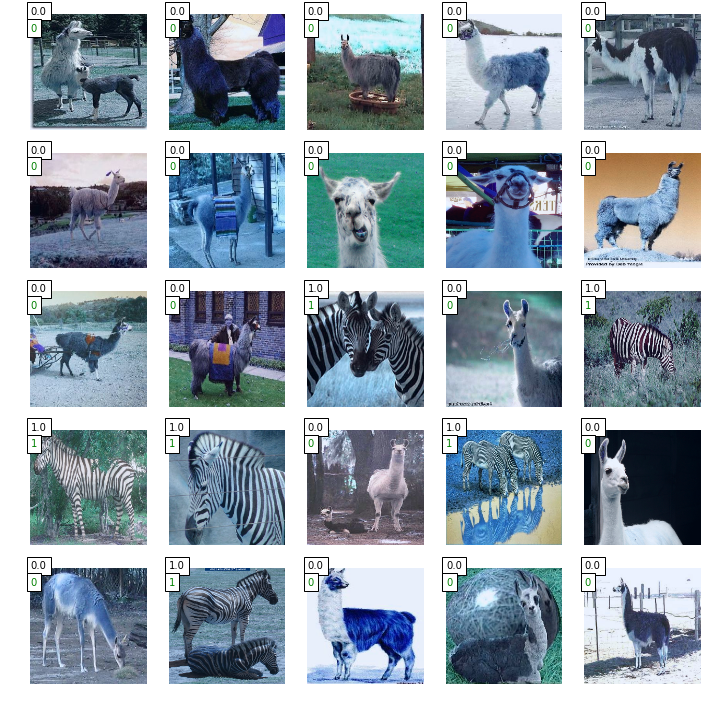

In [29]:
p_y = pred_fn(X_val[:25]).argmax(-1)

plt.figure(figsize=(12, 12))
for i in range(0, 25):
    plt.subplot(5, 5, i+1)
    plt.imshow(deprocess(X_val[i]))
    true = y_val[i]
    pred = p_y[i]
    color = 'green' if true == pred else 'red'
    plt.text(0, 0, true, color='black', bbox=dict(facecolor='white', alpha=1))
    plt.text(0, 32, pred, color=color, bbox=dict(facecolor='white', alpha=1))

    plt.axis('off')